# Time Series Forcasting


- TODO Mike this is too long, can't get through it all. Cut ARMA etc
- TODO too many blocks of text
- TODO go through prophet

In time series forcasting (TSF) the goal is to predict the future values using the behaviour of data in the past. We can use some of the tehniques we learned about in the last notebook. For instance, Holt-Winters methods can be used for forcasting as well as analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter("ignore")

We will load a subset of London Smart meters dataset. This dataset shows electricity consumption of 5,567 houses in London. We will only use the data for a single block. 

The data shows daily consumption of each house and various statistics regarding their daily consumption. The original data is from [UK Power Networks](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)

<AxesSubplot:xlabel='day'>

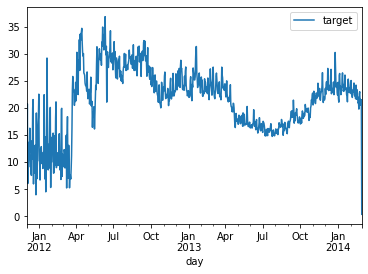

In [2]:
# Load data
df = block0 = pd.read_csv("../../data/processed/smartmeter/block_0.csv", parse_dates=['day'], index_col=['day'])[['energy_sum']]
# Get the mean over all houses, by day
df = df.groupby('day').mean()
# Rename energy to target
df = df.rename(columns={'energy_sum':'target'})
df.plot()

In forcasting we try to predict the next step, therefore it is essential that we specify the frequency of data so the model knows what we mean by next step. 

Pandas data frames have frequency property, which we need to set

In [3]:
df.index

DatetimeIndex(['2011-12-03', '2011-12-04', '2011-12-05', '2011-12-06',
               '2011-12-07', '2011-12-08', '2011-12-09', '2011-12-10',
               '2011-12-11', '2011-12-12',
               ...
               '2014-02-19', '2014-02-20', '2014-02-21', '2014-02-22',
               '2014-02-23', '2014-02-24', '2014-02-25', '2014-02-26',
               '2014-02-27', '2014-02-28'],
              dtype='datetime64[ns]', name='day', length=819, freq=None)

You can see at the bottom `freq` is set to `None`. We need to specify the the data is monthly and the dates are start of the month. So we use `freq = "MS"`.

In [4]:
df.index.freq = "1D"

__Note:__ Most of the algorithms have ways of infering the frequency if it is not set. But it is always safer to set it ourselves rather than leave it for the algorithms to figure out.

To measure whether we are doing well in our prediction or not, commonly we split the data into two parts, one for training the model and the other for evaluating the forcasting quality. In time series we train on the past and predict on the future, so the validation set needs to be in the future.  

The part that is used for taining is called training set and for time series it usually is the data from the beginning up to a certain point in time. The part that is used for evaluation is may be called validation set, test set, or evaluation set. The validation set comes right after the training set, because we use the training set to understand the behaviour of data and then we want to know what is going to happen right after that.


Let's split our data into training and validation set. Let's split in a way so that last 30% is in validation set and the rest in training set.

<AxesSubplot:xlabel='day'>

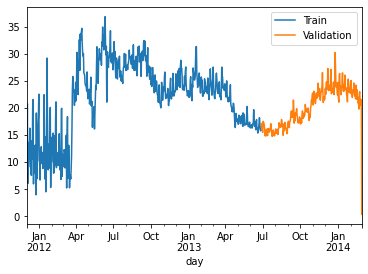

In [5]:
n_split = -int(len(df)*0.7)
df_train = df[:-n_split]
df_valid = df[-n_split:]

ax = df_train['target'].plot(legend=True, label="Train")
df_valid['target'].plot(ax=ax, legend=True, label="Validation")

__Change the value of alpha, beta, and gamma and see whether it improves the model.__

## Stationarity

A time series is considered stationary when its properties (mean and standard deviation) does not change with time. Therefore, any time series with trend or seasonality is not stationary. An example of stationary data is white noise:

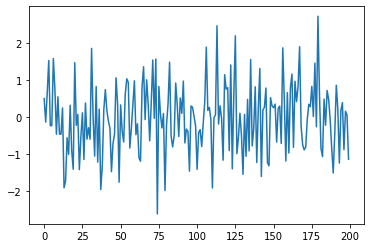

In [6]:
# Make random noise
np.random.seed(42)
random_noise = np.random.randn(200)
plt.plot(random_noise)

While it is easy to tell if a time series is not stationary when there is a clear trend, in some cases it might be pretty difficult to decide whether a time series is stationary or not. Therefore, we use statistical tests to make a decision.


#### Augmented Dickey-Fuller test

TODO mike understand or delete unit root

[Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) (ADF) is a statistical test for stationarity. We are not going to discuss the statistical details of this test, but what matters to us is the result. The null hpothesis of ADF is that there is a [unit root](https://en.wikipedia.org/wiki/Unit_root) in the time series. The alternative hypothesis is that the series is stationary. To use the test we are looking for the p-value. If p-value is lower than a hreshold (commonly 0.05), it means the null hypothesis is rejected and therefore the time series is stationary.<br>
Let's test it on our data.

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_p_value(data):
    res = adfuller(data)
    return res[1]

In [8]:
adf_p_value(df["target"])

0.13326955063934082

The function returns many values, but the one that we are interested in is p-value, which the second value. If it is less than 0.05, it means time series is stationary. In this case it is far from 0.05 and that is what we expected as the data has clear trend.<br>
Now let's turn it into a function that only return the p-value and run the test on white noise.

In [9]:
adf_p_value(random_noise)

2.5431251122128163e-27

The value is very small, which suggests we can reject the null hypothesis and therefore the series is stationary.

What if we remove trend and seasonality from the data using STL method?

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

''

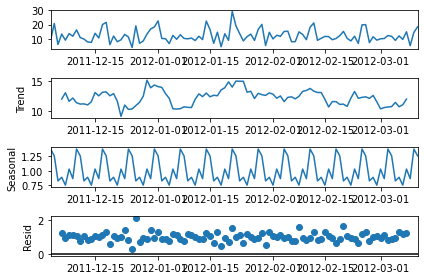

In [11]:
res = seasonal_decompose(df[:100], model="mul")
res.plot()
''

If we remove the seasonal and trend component what is left is the residuals.<br>
The residuals might have `NaN` in it. If so, we need to remove them before performing the test.

In [12]:
adf_p_value(res.resid.dropna())

1.0222024167074671e-10

The residual is stationary.

__Why is it important if a time series is stationary or not?__<br>
We know that in a stationary time series the characteristics will remain constant. This makes it easier to predict their future behaviour as we expect them to behave similarly. But when the series is not stationary we don't know how it is going to behave in the future. In reality, most of the time series we are going to work with are not stationary. But using various techniques we might be able to transform them into a stationary time series. This is exactly what we just did. We use STL to remove the trend and seasonality to get a stationary time series.

Another technique to make a time series stationary is differencing. Differencing means that we calculate the difference between two consecutive points in time. Then we use the differences for forcasting.<br>
Let's see how differencing will affect our data. Pandas has a builtin method for differencing (`.diff()`):

In [13]:
df.diff()

,target
day,
2011-12-03,NaN
2011-12-04,11.756000
2011-12-05,-14.743000
2011-12-06,7.302000
2011-12-07,-4.260000
...,...
2014-02-24,-2.219690
2014-02-25,0.797357
2014-02-26,-1.088286


We need to get rid of `NaN` so we can run the test.

In [14]:
adf_p_value(df.diff().dropna()["target"])

2.7328727912503624e-06

As we can see p-value is below the 0.05 threshold, which means differencing helped to convert data into stationary time series. <br>
In some cases you might need to perform differencing multiple times to reach stationary results.

In [15]:
adf_p_value(df.diff(2).dropna()["target"])

3.469487815047729e-06

## Autocorrelation

Another characteristics of a time series is autocorrelation. Autocorrelation is simply the correlation between the points in the time series and the points before them (sometimes called lagged values).

The shaded area is the confidence threshold on the correlation using Bartlett's formula $1/\sqrt{N}$ which assumes a guassian distribution. If a correlations is below this threshold is it's likely to be a coincidence.

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

''

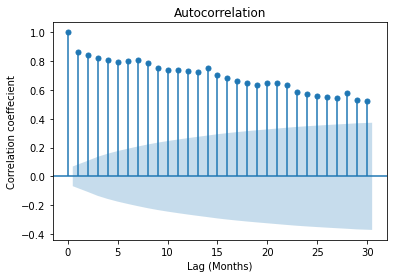

In [17]:
plot_acf(df)
plt.xlabel('Lag (Months)')
plt.ylabel('Correlation coeffecient')
''

The points closer together in time have higher correlation compared to the points further apart. This is an expected behaviour. However, how quickly does the correlation decreases is important.

## Autoregressive models (AR)
An [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model), is a time series model which assumes a linear relationship between each point in time and its past $p$ points.

$$y_t=c+\sum_{i=1}^{p}\phi_iy_{t-i}$$
For instance a first order AR (also shown as AR(1)) can be written as:<br>
$$y_t=c+\phi_1 y_{t-1}$$
This model can be found in statsmodels in ar_model submodule.

In [18]:
# This is to avoid some warning messages from statsmodels
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
from statsmodels.tsa.ar_model import AR, ARResults

Let's try an AR model on our data. 

In [20]:

model = AR(df_train)

# Then we train the model specifying the order of AR. Let's start by trying `1`.
trained_model = model.fit(
    maxlag=2,  
    trend='nc',
)

# Now the model is trained. We can view model's values:
print('params\n', trained_model.params)

params
 L1.target    0.576877
L2.target    0.416970
dtype: float64


More importantly, we can forecast using the trained model. To do that, we need to at which time-step in the training data the model should stat and at which time-step it should stop. Since we want the predictions for validation data, we need to start right after last index of training data, so we use starting index as `len(df_train)` (Note that indexing starts from `0`).<br> Likewise, the last index would be sum of the lengths of training and validation sets.

<AxesSubplot:xlabel='day'>

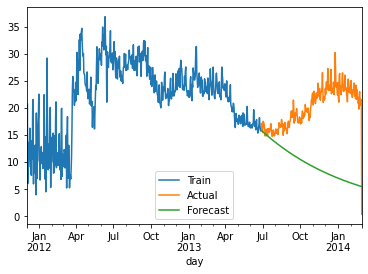

In [21]:
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = trained_model.predict(start, end)

fig = plt.figure()
ax = fig.gca()
df_train['target'].plot(ax=ax, legend=True, label="Train")
df_valid['target'].plot(ax=ax, legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")

It's not very close. But how close? We need to put a value on the goodness of the result. To do this, we can use metrics. There are various metrics which can be used here, such as root of mean squared error (RMSE), mean squered error (MSE), mean absolute error (MAE), $R^2$, and many more. Sometimes for a certain application you might need to use particular metric.<br>

We will use Mean Absolute Percentage Error.

There is a package called Scikit Learn which is a commonly used for machine learning and data science. This package contains many useful functions and algorithms. One of them is the metrics submodule where various types of metrics are available. 

In [22]:
from sklearn.metrics.regression import _check_reg_targets

def mape(y_true, y_pred, epsilon=1e-3):
    """
    This function already exists in newer version of sklearn.
    
    https://scikit-learn.org/dev/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    """
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, 'uniform_average')
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    return np.average(mape)




That's not so good! Let's calculate mean absolute error:

In [23]:
mape(df_valid, forecast)

0.5421636428694006

Now let's try larger models by increasing order of AR. It looks at a longer term trend now.

0.40327799329978425

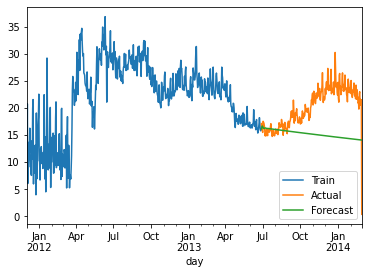

In [24]:
model = AR(df_train)
model = model.fit(maxlag=7,  trend='nc')
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = model.predict(start, end)
fig = plt.figure()
ax = fig.gca()
df_train['target'].plot(ax=ax, legend=True, label="Train")
df_valid['target'].plot(ax=ax, legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")
mape(df_valid, forecast)

<div class="alert alert-success">
  <h2>Exercise</h2>

  Try a few other values yourself and see if you get a better/lower result  than mape=0.4
  
  - try trend='nc', which makes it return to the mean.
  - try a great lag, which gives it more parameters
    
    
  Does it *look* better as well? Is MAPE capturing your intuition about a good fit?
      

  <details>
  <summary><b>→ Hints</b></summary>

  * try `model.fit(maxlag=30,  trend='nc')`
      
  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
    model = AR(df_train)
    model = model.fit(maxlag=30,  trend='nc')
    start = len(df_train)
    end = len(df_train) + len(df_valid) - 1
    forecast = model.predict(start, end)
    fig = plt.figure()
    ax = fig.gca()
    df_train['target'].plot(ax=ax, legend=True, label="Train")
    df_valid['target'].plot(ax=ax, legend=True, label="Actual")
    forecast.plot(ax=ax, legend=True, label="Forecast")
    mape(df_valid, forecast)
  ```

  </details>

  </div>



0.40327799329978425

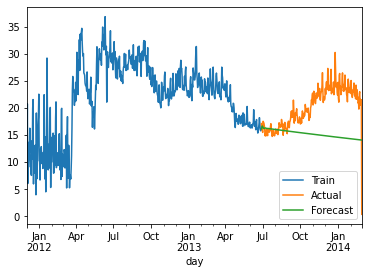

In [25]:
model = AR(df_train)
model = model.fit(maxlag=7,  trend='nc')
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = model.predict(start, end)
fig = plt.figure()
ax = fig.gca()
df_train['target'].plot(ax=ax, legend=True, label="Train")
df_valid['target'].plot(ax=ax, legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")
mape(df_valid, forecast)

# Prophet
Prophet is a time series analysis and forecasting package developed by Facebook. Prophet allows you to train forecasting models with minimal need to adjust the models parameters. Prophet is particularly useful when you are dealing with data that has multiple levels of seasonality.

Let's start by importing the library. The name of the package is `fbprophet`.

In [26]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


Prophet needs the input data to be in a very specific format. The data needs to have a column containing daily dates called `"ds"`, and a column containing values named `"y"`. So we create a new data frame and use the required column names.

In [27]:
df = pd.DataFrame({"ds": df.index, "y": df["target"]}).reset_index(drop=True)
df

,ds,y
0,2011-12-03,9.007000
1,2011-12-04,20.763000
2,2011-12-05,6.020000
3,2011-12-06,13.322000
4,2011-12-07,9.062000
...,...,...
814,2014-02-24,20.788405
815,2014-02-25,21.585762
816,2014-02-26,20.497476
817,2014-02-27,21.492690


Now the data is ready. We need to create a Prophet model and train it on the data.

In [28]:
%%time
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 1.51 s, sys: 188 ms, total: 1.7 s
Wall time: 1.7 s


And that's it! The model is trained and ready to be used.<br>
Let's forecast the next year using the model. To forecast using Prophet we need to first create an empty dataframe for future values. This data frame contains the future dates. Then we feed this dataframe to `.predict()` and will get the forecasted values.

In [29]:
future = model.make_future_dataframe(periods=365)
future.head()

,ds
0,2011-12-03
1,2011-12-04
2,2011-12-05
3,2011-12-06
4,2011-12-07


__Note:__ as you can see this data frame has only future dates.

In [30]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-12-03,6.709838,5.822819,13.750637,6.709838,6.709838,3.050769,3.050769,3.050769,1.225828,1.225828,1.225828,1.824941,1.824941,1.824941,0.0,0.0,0.0,9.760608
1,2011-12-04,6.818741,6.551400,13.883523,6.818741,6.818741,3.290452,3.290452,3.290452,1.277840,1.277840,1.277840,2.012612,2.012612,2.012612,0.0,0.0,0.0,10.109193
2,2011-12-05,6.927644,5.087478,12.632050,6.927644,6.927644,1.858784,1.858784,1.858784,-0.328799,-0.328799,-0.328799,2.187584,2.187584,2.187584,0.0,0.0,0.0,8.786428
3,2011-12-06,7.036547,5.207642,12.444393,7.036547,7.036547,1.815120,1.815120,1.815120,-0.532190,-0.532190,-0.532190,2.347311,2.347311,2.347311,0.0,0.0,0.0,8.851667
4,2011-12-07,7.145450,5.022561,12.712987,7.145450,7.145450,1.737233,1.737233,1.737233,-0.752288,-0.752288,-0.752288,2.489521,2.489521,2.489521,0.0,0.0,0.0,8.882682


The result contains various components of the time series. The forecasted values can be found on `yhat` column. It is difficult to see how model has performed, so let's plot the results. We can do that using Prophets built-in plot function.

''

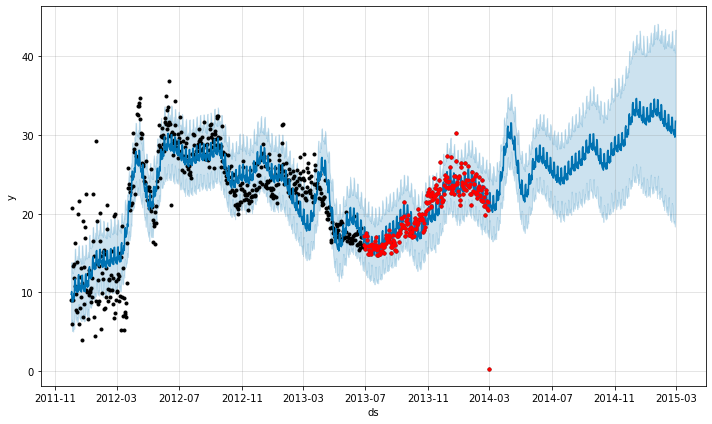

In [31]:
fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['target'], 'k.', c='r', label='validation')
''

As you can see at some periods the predictions are poor and at some points they are pretty close. Let's have a closer look at the future.

(15.0, 30.0)

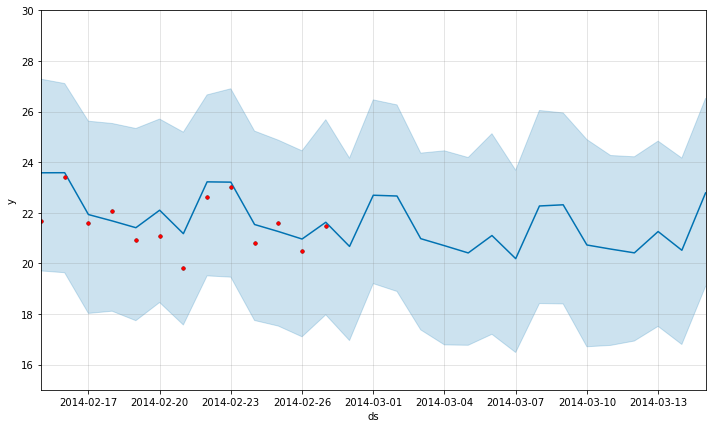

In [32]:
fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['target'], 'k.', c='r', label='validation')
plt.xlim(pd.to_datetime(["2014-02-15", "2014-03-15"]))
plt.ylim([15, 30])

The model has found annual and weekly seasonalities. We can have closer look at these components using `.plot_components()`

1

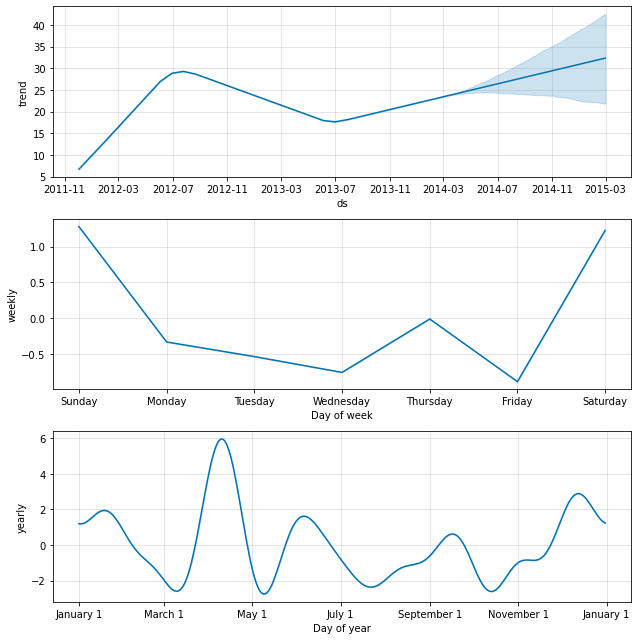

In [33]:
model.plot_components(forecast)
1

Now we can see which days of the week are associated with more energy consumption (it's not suprising to see Saturday and Sunday) and also how time of the year affects the energy consumption.

## Cross_validation

We created a model and forecasted the future. But we still don't know how good the model is. So like before we need a training and a validation set. We train a model on a training set, and then measure the accuracy of its prediction on validation set using metrics.<br>
One issue with this approach is that even when we get a value for predictions accuracy of a model, how do we know this value is reliable. Let's say we are comparing two models and mean absolute error for model A is 0.5 and for model B is 0.45. How do we know that B is better than A and it didn't just get lucky over this data set? One way to ensure which one is better is by comparing them over multiple sections of data sets. This approach is called cross validation. In Prophet, we start by training the model over the data from the eginning up to a certain point (cut-off point) and then predict for a few time steps (Horizon). Then we move cut-off point by a certain period and repeat the process. We can then calculate the metrics for each model over multiple sections of the data and have a better comparison at the end.

You need to specify the following inputs:
- initial: The initial length of training set.
- period: How much the cut-off point is moved after each training process.
- horizon: Length of forecasting period for which the metrics are calculcated.


In [34]:
from fbprophet.diagnostics import cross_validation

# Cross validation
cv = cross_validation(model, initial="365 days", period="90 days", horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2013-02-03 00:00:00 and 2014-01-29 00:00:00


In [35]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-02-04,24.419159,20.985680,28.007009,22.283813,2013-02-03
1,2013-02-05,24.175647,20.486007,27.510714,22.148292,2013-02-03
2,2013-02-06,23.747585,20.371062,27.139841,23.066604,2013-02-03
3,2013-02-07,24.954565,21.551121,28.544345,22.582937,2013-02-03
4,2013-02-08,23.628796,20.152346,27.100424,23.103750,2013-02-03


The cross validation data frame shows the forecasted value (yhat) and its confidence range (yhat_upper and yhat_lower). We can use `performance_metrics` function to calculate the metrics.

In [36]:
from fbprophet.diagnostics import performance_metrics

perf = performance_metrics(cv)
perf.index = pd.Index(perf.horizon.dt.days, name='days')
perf

,horizon,mse,rmse,mae,mape,mdape,coverage
days,,,,,,,
3,3 days,4.930412,2.220453,1.882101,0.094323,0.091536,0.933333
4,4 days,7.149672,2.673887,2.315748,0.117683,0.113567,0.866667
5,5 days,8.962108,2.993678,2.520200,0.129223,0.113567,0.800000
6,6 days,9.391356,3.064532,2.593408,0.133963,0.119620,0.800000
7,7 days,8.551588,2.924310,2.489481,0.129422,0.100155,0.733333
8,8 days,8.494296,2.914498,2.413914,0.123772,0.074340,0.733333
9,9 days,8.016260,2.831300,2.212309,0.111825,0.068722,0.733333
10,10 days,9.336184,3.055517,2.405117,0.120729,0.079601,0.733333
11,11 days,10.171483,3.189276,2.531028,0.128934,0.079601,0.666667


The dataframe above has multiple metrics for model's predictions.


<font color = red>__Note:__ In some versions of Prophet all the result is aggregated based on how far forecasted point is from cut-off point. If this is not the case, then you will see horizon column has repeated values (for instance multiple "10 days" entries) and you will need to use groupby.</font>

In [37]:
# uncomment and run if performance metrics are not aggregated based on horizon days

# perf = perf.groupby('horizon').mean()
# perf

Before running the next cell look at the performance data frame and find the first and last horizon days and enter it in the next cell as `start` and `end`.

Text(0.5, 1.0, 'Mean Absolute Percent Error of forecasts')

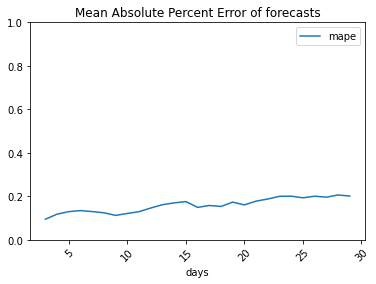

In [38]:
perf[['mape']][:-1].plot(ylim=[0,1])
plt.xticks(rotation=45)
plt.title("Mean Absolute Percent Error of forecasts")

This plot shows the further we are from the cut-off point the larger the error is, which is what we expect. Now, let's compare this model with another one.<br>


## Holidays

Prophet has the ability to include the effect of holidays on the time series as well. Let's see whether adding public holidays to the model will make it any better.

In [39]:
holiday_df = pd.read_csv(
    "../../data/processed/smartmeter/uk_bank_holidays.csv",
    names=("ds", "holiday"),
    header=0,
)
holiday_df.head()

,ds,holiday
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [40]:
model2 = Prophet(holidays=holiday_df)
model2.fit(df)

# Cross validation
cv2 = cross_validation(model2, initial="365 days", period="90 days", horizon="30 days")
perf2 = performance_metrics(cv2)
perf2.index = pd.Index(perf2.horizon.dt.days, name='days')
perf2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2013-02-03 00:00:00 and 2014-01-29 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
days,,,,,,,
3,3 days,4.784714,2.187399,1.845297,0.092426,0.083060,0.933333
4,4 days,6.905119,2.627759,2.230242,0.113070,0.096638,0.866667
5,5 days,8.843114,2.973737,2.444073,0.124933,0.096638,0.800000
6,6 days,9.203304,3.033695,2.499820,0.128832,0.098237,0.800000
7,7 days,8.381819,2.895137,2.387112,0.123974,0.080631,0.733333
8,8 days,8.350976,2.889806,2.310033,0.118265,0.068496,0.733333
9,9 days,8.005332,2.829370,2.104867,0.106003,0.063930,0.733333
10,10 days,9.214241,3.035497,2.300488,0.115010,0.076475,0.733333
11,11 days,10.018369,3.165181,2.403967,0.122034,0.076475,0.666667


In [41]:
# uncomment and run if performance metrics are not aggregated based on horizon days

# perf2 = perf2.groupby('horizon').mean()
# perf2

Now let's compare the models.

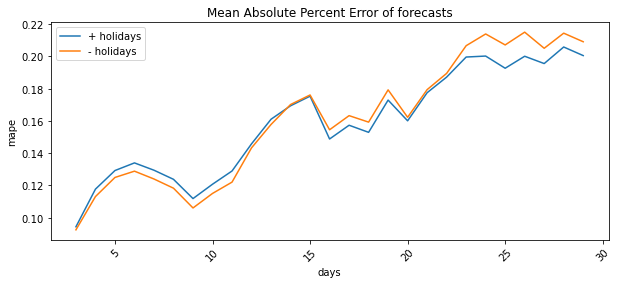

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))
perf['mape'][:-1].plot(ax=ax, label="+ holidays")
perf2['mape'][:-1].plot(ax=ax, label="- holidays")
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)
plt.title("Mean Absolute Percent Error of forecasts")
plt.ylabel("mape")
plt.legend()

It seems adding holidays slightly lowered the error for the first couple of weeks.

We can separately plot the models including the errors for all the horizons.

(0.0, 1.0)

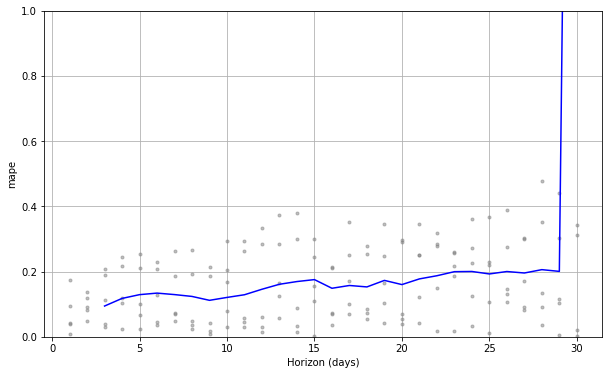

In [43]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(cv, metric="mape")
plt.ylim(0, 1)

## Trends

One interesting feature of Prophet is that it can identify when the trend of the data is changing. We can add these change points to the plot as well.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


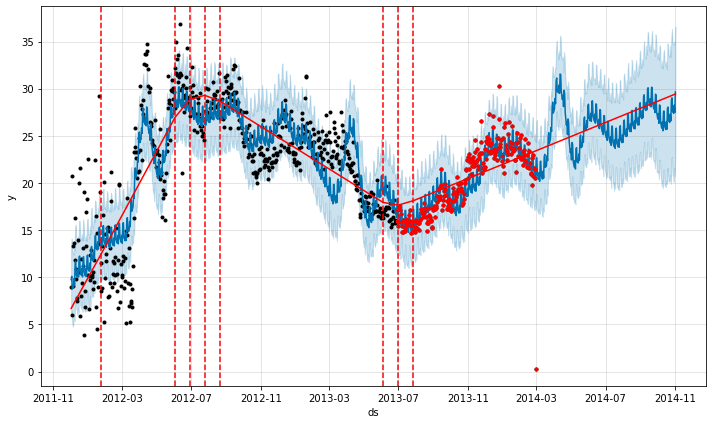

In [44]:
from fbprophet.plot import add_changepoints_to_plot

model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=len(df_valid))
forecast = model.predict(future)
fig = model.plot(forecast)
ax = fig.gca()
a = add_changepoints_to_plot(ax, model, forecast)
ax.plot(df_valid.index, df_valid['target'], 'k.', c='r', label='validation')

We can change the sensitivity of the model to the changes by setting `changepoint_prior_scale`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


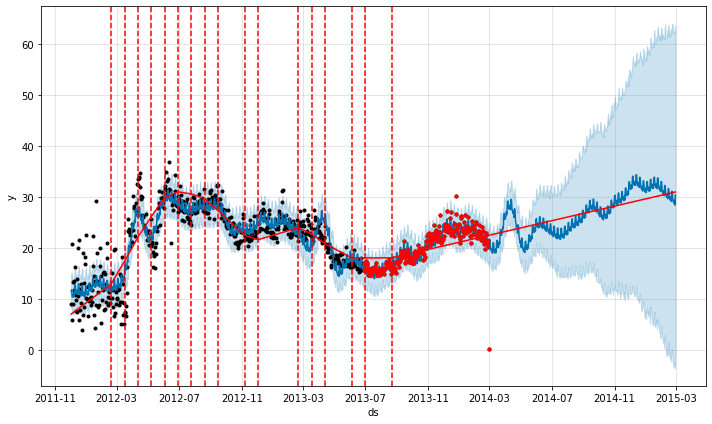

In [45]:
model = Prophet(changepoint_prior_scale=0.2)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig.gca().plot(df_valid.index, df_valid['target'], 'k.', c='r', label='validation')

Prophet has many other parameters you can set to improve your model, including seasonality, growth type, etc. You can find more information about Facebook Prophet [here](https://facebook.github.io/prophet/docs/diagnostics.html).

# Exercise

Now that we have learned about various time series forecasting techniques, try to apply some of these techniques to another block of houses from electricity usage.

<AxesSubplot:xlabel='day'>

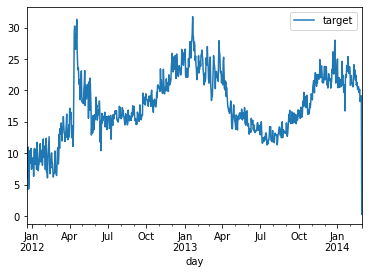

In [46]:
df = block0 = pd.read_csv("../../data/processed/smartmeter/block_1.csv", parse_dates=['day'], index_col=['day'])[['energy_sum']]
df = df.groupby('day').mean()
df = df.rename(columns={'energy_sum':'target'})
df.plot()

# Further Reading
- [Introduction to the Fundamentals of Time Series Data and Analysis](https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/)
- [The Complete Guide to Time Series Analysis and Forecasting](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
- [Generate Quick and Accurate Time Series Forecasts using Facebook’s Prophet](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/#:~:text=Prophet%20is%20an%20open%20source,of%20custom%20seasonality%20and%20holidays!)
- [Facebook Prophet Documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)


<AxesSubplot:xlabel='day'>

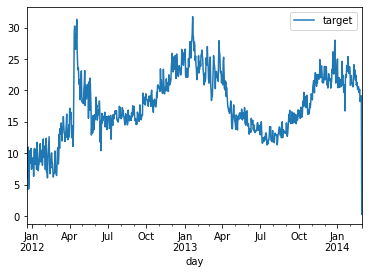

In [47]:
df = block0 = pd.read_csv("../../data/processed/smartmeter/block_1.csv", parse_dates=['day'], index_col=['day'])[['energy_sum']]
df = df.groupby('day').mean()
df = df.rename(columns={'energy_sum':'target'})
df.plot()

,ds,y
time,,
2015-01-01 00:00:00,2015-01-01 00:00:00,291.066132
2015-01-01 01:00:00,2015-01-01 01:00:00,291.617493
2015-01-01 02:00:00,2015-01-01 02:00:00,292.164337
2015-01-01 03:00:00,2015-01-01 03:00:00,292.632446
2015-01-01 04:00:00,2015-01-01 04:00:00,292.288147
...,...,...
2016-12-31 19:00:00,2016-12-31 19:00:00,285.170807
2016-12-31 20:00:00,2016-12-31 20:00:00,285.048920
2016-12-31 21:00:00,2016-12-31 21:00:00,285.067627


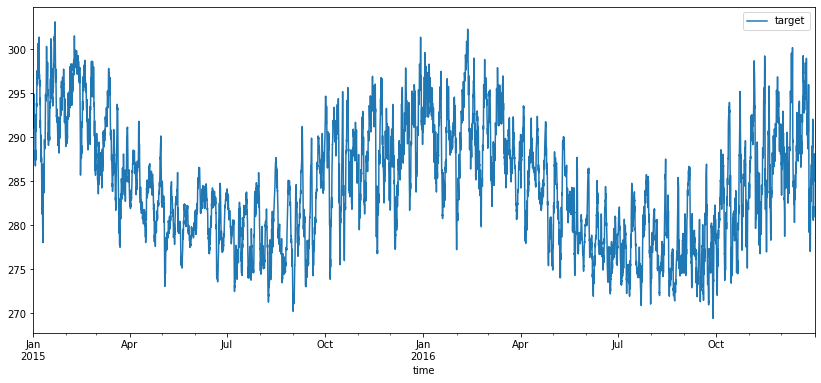

In [92]:
import xarray as xr
ds_perth = xr.open_dataset(
    "../../data/processed/weatherbench/perth_5.625deg_z_t.nc"
).drop(["lon", "lat"]).sel(time=slice('2015', '2016'))
df = ds_perth['t'].to_dataframe()[['t']]
df = df.rename(columns={'t':'target'})['2015':'2016']
df.plot(figsize=(14,6))
df = pd.DataFrame({"ds": df.index, "y": df["target"]})#.reset_index(drop=True)
df

<AxesSubplot:xlabel='time'>

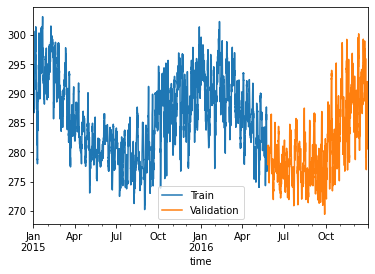

In [93]:
n_split = -int(len(df)*0.7)
df_train = df[:-n_split]
df_valid = df[-n_split:]

ax = df_train['y'].plot(legend=True, label="Train")
df_valid['y'].plot(ax=ax, legend=True, label="Validation")

In [101]:
%%time
model = Prophet()
# add same periods as bcm see https://en.wikipedia.org/wiki/Theory_of_tides (additive)
model.add_seasonality(name='Moon2', period=12.4206012/24, fourier_order=1, prior_scale=40)
model.add_seasonality(name='Sun2', period=12/24, fourier_order=1, prior_scale=30)
model.add_seasonality(name='N2', period=12.65834751/24, fourier_order=1, prior_scale=10)

model.add_seasonality(name='K1', period=23.93447213/24, fourier_order=1, prior_scale=20)
model.add_seasonality(name='O1', period=25.81933871/24, fourier_order=1, prior_scale=10)

model.add_seasonality(name='Mm', period=27.554631896, fourier_order=1, prior_scale=4)
model.add_seasonality(name='Ssa', period=182.628180208, fourier_order=1, prior_scale=4)
model.add_seasonality(name='Sa', period=365.256360417, fourier_order=1, prior_scale=4)


model.add_seasonality(name='M4', period=6.210300601/24, fourier_order=1, prior_scale=2)
model.add_seasonality(name='M6', period=4.140200401/24, fourier_order=1, prior_scale=2)
model.add_seasonality(name='MK3', period=8.177140247/24, fourier_order=1, prior_scale=2)
model.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


CPU times: user 21.1 s, sys: 173 ms, total: 21.3 s
Wall time: 21.2 s


In [102]:
# future = model.make_future_dataframe(periods=365)

forecast = model.predict(df_valid)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,K1,K1_lower,K1_upper,M4,...,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-05-26 16:00:00,289.302768,277.308255,286.917378,289.302768,289.302768,-0.071262,-0.071262,-0.071262,-0.005116,...,0.110017,0.110017,0.110017,0.784620,0.784620,0.784620,0.0,0.0,0.0,281.928444
1,2016-05-26 17:00:00,289.305911,277.193152,287.082047,289.305911,289.305911,0.002032,0.002032,0.002032,-0.005264,...,-0.011699,-0.011699,-0.011699,0.783874,0.783874,0.783874,0.0,0.0,0.0,281.920366
2,2016-05-26 18:00:00,289.309054,277.045823,286.926397,289.309054,289.309054,0.075186,0.075186,0.075186,-0.000468,...,-0.146637,-0.146637,-0.146637,0.780902,0.780902,0.780902,0.0,0.0,0.0,281.925377
3,2016-05-26 19:00:00,289.312197,277.447941,286.612945,289.312197,289.312197,0.143188,0.143188,0.143188,0.004768,...,-0.280074,-0.280074,-0.280074,0.775687,0.775687,0.775687,0.0,0.0,0.0,281.930435
4,2016-05-26 20:00:00,289.315339,276.716085,286.742502,289.315339,289.315339,0.201380,0.201380,0.201380,0.005526,...,-0.381421,-0.381421,-0.381421,0.768227,0.768227,0.768227,0.0,0.0,0.0,281.933179


''

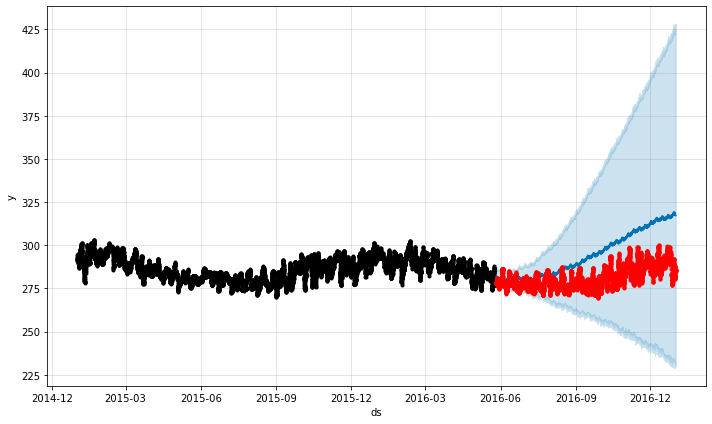

In [103]:
fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
''

1

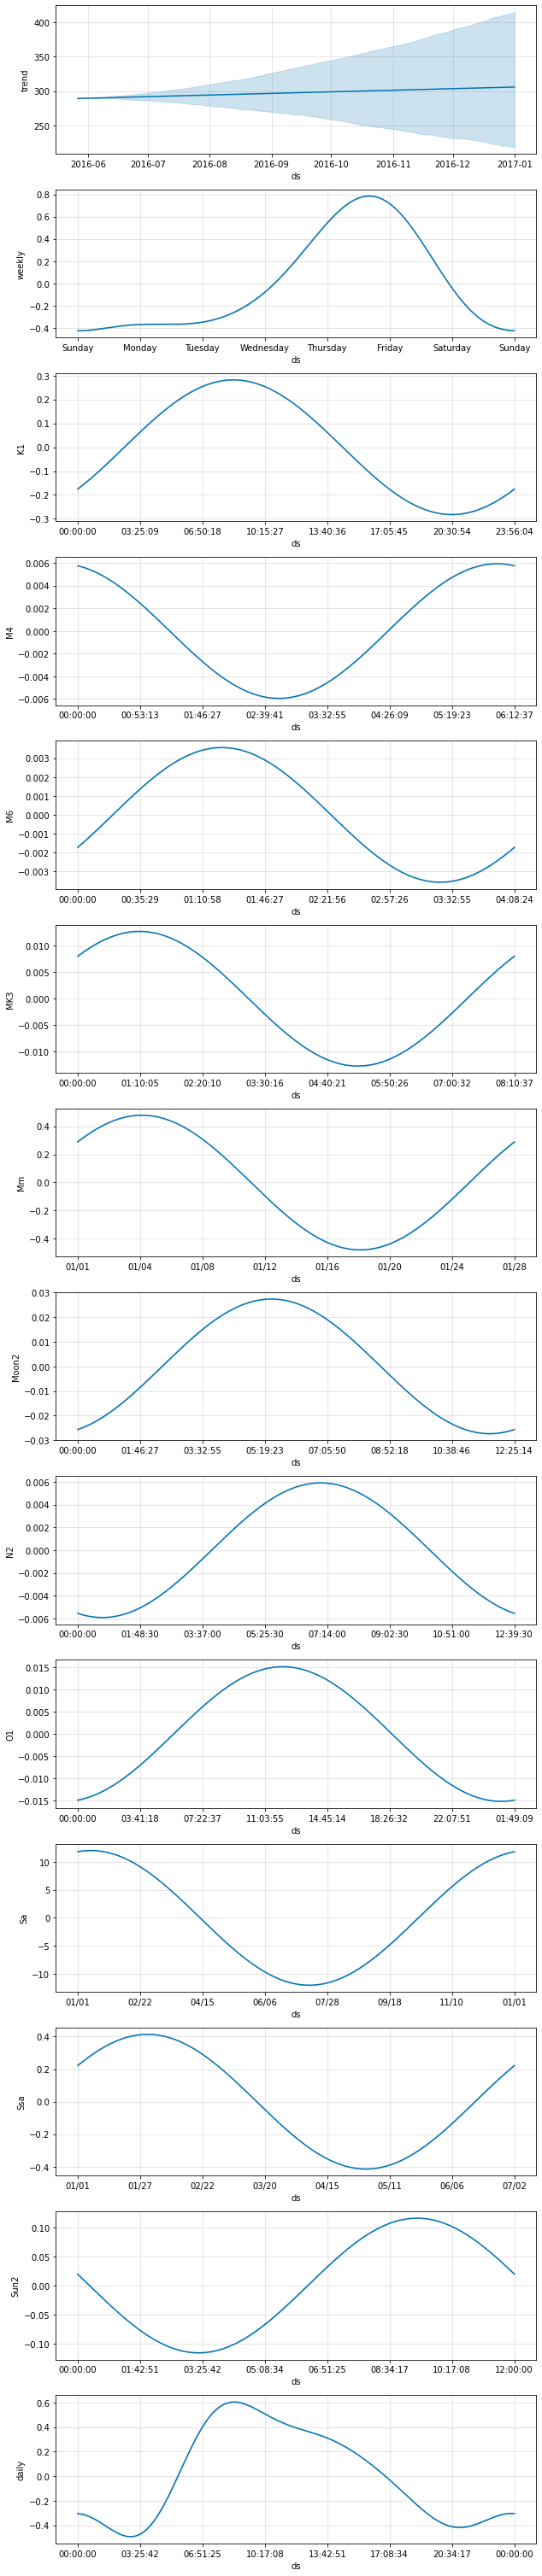

In [104]:
model.plot_components(forecast)
1

## Custom Seasonality

This library is made by facebook for tracking user trends. That means it is set up for growing tends to do with humans, with holidays and weekly seasonality. What if we have data that has a differen't seasonality?

Lets try on significant wave height from Buoy 44025

Data from NOAA’s National Data Buoy Center - Buoy 44025

In [237]:
# xd = xr.open_dataset("https://dods.ndbc.noaa.gov/thredds/dodsC/data/mmbcur/41022/41022m1996.nc?time[0:1:5471],water_spd[0:1:0][0:1:0][0:1:0]")
# df = xd.isel(latitude=0, longitude=0, time_1=0).to_dataframe()
# df

<xarray.Dataset>
Dimensions:                   (HEIGHT_ABOVE_SENSOR: 30, TIME: 28357)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2011-12-21T08:00:00.00000...
  * HEIGHT_ABOVE_SENSOR       (HEIGHT_ABOVE_SENSOR) float32 8.011217 ... 182....
    LATITUDE                  float64 ...
    LONGITUDE                 float64 ...
    NOMINAL_DEPTH             float32 ...
Data variables:
    TIMESERIES                int32 ...
    VCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    UCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    UCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    WCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    WCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC1                    (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC1_quality_control    (TIME, HEIGHT_ABOVE_SENSOR) float32 .

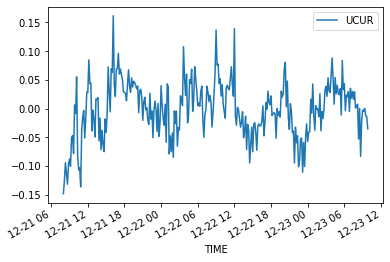

In [324]:
# from https://catalogue-imos.aodn.org.au/geonetwork/srv/api/records/ae86e2f5-eaaf-459e-a405-e654d85adb9c
xd = xr.open_dataset("/home/wassname/Downloads/IMOS_ANMN-WA_AETVZ_20111221T060300Z_WATR20_FV01_WATR20-1112-Continental-194_END-20120704T050500Z_C-20200916T043212Z.nc")
print(xd)
name='UCUR'
df = xd.isel(HEIGHT_ABOVE_SENSOR=0)[name].isel(TIME=slice(0, -1000)).to_dataframe()[[name]]
df.iloc[:300].plot()

df = pd.DataFrame({"ds": df.index, "y": df[name]})#.reset_index(drop=True)
# df.y.plot()
# df
# df



In [322]:
xd#.info()

<xarray.Dataset>
Dimensions:                   (HEIGHT_ABOVE_SENSOR: 30, TIME: 28357)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2011-12-21T08:00:00.00000...
  * HEIGHT_ABOVE_SENSOR       (HEIGHT_ABOVE_SENSOR) float32 8.011217 ... 182....
    LATITUDE                  float64 -31.72
    LONGITUDE                 float64 115.0
    NOMINAL_DEPTH             float32 194.0
Data variables:
    TIMESERIES                int32 1
    VCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    UCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    UCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    WCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    WCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC1                    (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC1_quality_control    (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC2                    (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC2_quality_control    (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC3                    (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSIC3_quality_control    (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    TEMP                      (TIME) float32 20.0 19.77 19.55 ... 15.47 15.65
    TEMP_quality_control      (TIME) float32 1.0 1.0 1.0 1.0 ... 4.0 4.0 4.0 4.0
    PRES_REL                  (TIME) float32 202.251 202.266 ... 0.662 0.661
    PRES_REL_quality_control  (TIME) float32 1.0 1.0 1.0 1.0 ... 4.0 4.0 4.0 4.0
    BAT_VOLT                  (TIME) float32 18.4 18.4 18.4 ... 12.7 12.7 12.7
    BAT_VOLT_quality_control  (TIME) float32 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0 4.0
    SSPD                      (TIME) float32 1521.4 1520.8 ... 1508.1 1508.7
    SSPD_quality_control      (TIME) float32 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0 4.0
    PITCH                     (TIME) float32 -0.4 -0.4 -0.4 -0.3 ... 1.0 1.1 0.9
    PITCH_quality_control     (TIME) float32 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0 4.0
    ROLL                      (TIME) float32 0.2 0.2 0.1 0.2 ... 1.1 1.1 1.1 1.3
    ROLL_quality_control      (TIME) float32 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0 4.0
    HEADING                   (TIME) float32 246.38333 246.48334 ... 206.48334
    HEADING_quality_control   (TIME) float32 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0 4.0
    DEPTH                     (TIME) float32 200.74838 200.76328 ... 0.6564099
    DEPTH_quality_control     (TIME) float32 1.0 1.0 1.0 1.0 ... 4.0 4.0 4.0 4.0
    ABSI1                     (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSI1_quality_control     (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSI2                     (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSI2_quality_control     (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSI3                     (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    ABSI3_quality_control     (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VEL1                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VEL1_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VEL2                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VEL2_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VEL3                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    VEL3_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    CSPD                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    CSPD_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    CDIR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    CDIR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
Attributes:
    abstract:                      ANMN Two Rocks, WA, 202m mooring, Dec2011 ...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Snell, Mark
    author_email:                  mark.snell@csiro.au
    cdm_data_type:                 St

In [265]:
# xd = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/41012/41012.ncml')
# xd = xd.sel(time=slice('2017', '2018')).isel(latitude=0, longitude=0)
# xd

In [325]:
# # see https://datalab.marine.rutgers.edu/2020/03/seasonal-cycle-and-anomaly-at-ndbc-44025/
# xd = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44025/44025.ncml')
# df = xd.sea_surface_temperature.sel(time=slice('2017', '2018')).isel(latitude=0, longitude=0).to_dataframe()[['sea_surface_temperature']]
# # df = pd.read_csv('../../data/processed/dodsC/wave_height.csv', parse_dates=['time']).set_index('time')

# df = pd.DataFrame({"ds": df.index, "y": df["sea_surface_temperature"]})#.reset_index(drop=True)
# df.y.plot()
# df



In [326]:
# # see https://datalab.marine.rutgers.edu/2020/03/seasonal-cycle-and-anomaly-at-ndbc-44025/
# xd = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44025/44025.ncml')
# df = xd.wave_height.sel(time=slice('2017', '2018')).isel(latitude=0, longitude=0).to_dataframe()[['wave_height']]
# # df = pd.read_csv('../../data/processed/dodsC/wave_height.csv', parse_dates=['time']).set_index('time')

# df = pd.DataFrame({"ds": df.index, "y": df["wave_height"]})#.reset_index(drop=True)
# df.y.plot()
# df

<AxesSubplot:xlabel='TIME'>

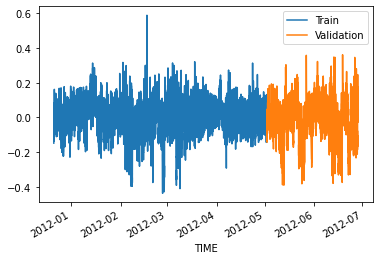

In [327]:

n_split = -int(len(df)*0.7)
df_train = df[:-n_split]
df_valid = df[-n_split:]

ax = df_train['y'].plot(legend=True, label="Train")
df_valid['y'].plot(ax=ax, legend=True, label="Validation")
# plt.ylabel('significant wave height')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


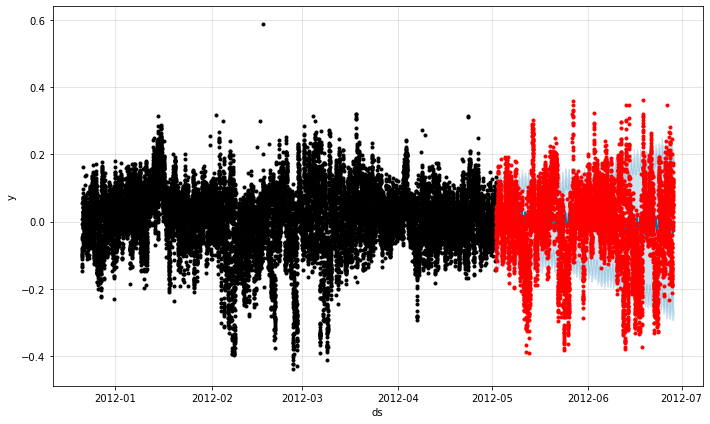

CPU times: user 1min 4s, sys: 4.79 s, total: 1min 9s
Wall time: 33.2 s


''

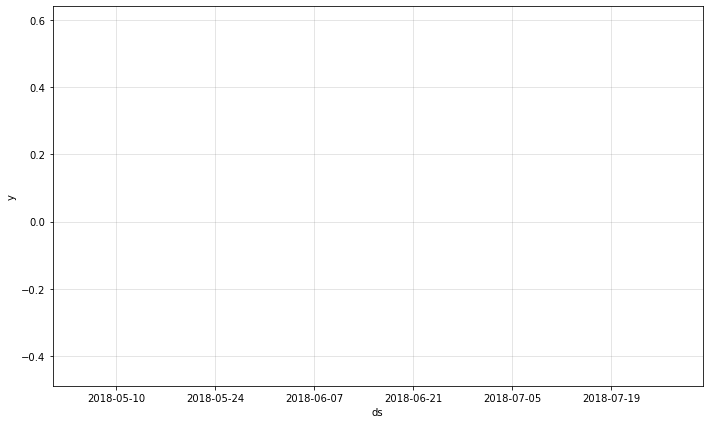

In [328]:
%%time
model = Prophet(
    changepoint_range=0.8,
)
model.fit(df_train)

forecast = model.predict(df_valid)
forecast.index = forecast.ds

fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.show()

fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.xlim(pd.Timestamp('2018-05'), pd.Timestamp('2018-08'))
''

(-0.1, 0.2)

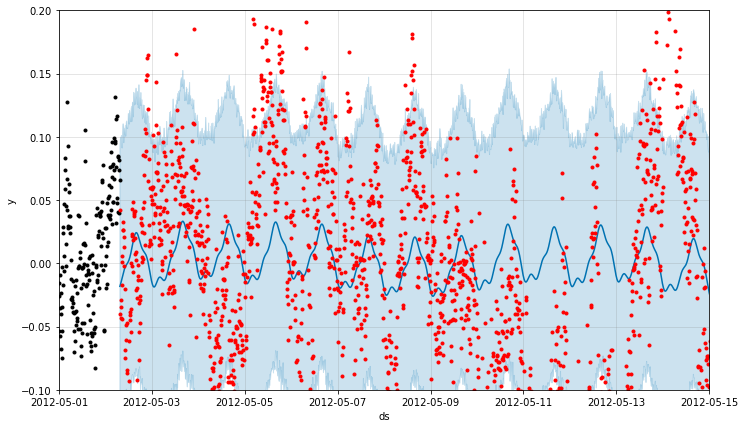

In [329]:
fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.xlim(pd.Timestamp('2012-05'), pd.Timestamp('2012-05-15'))
plt.ylim(-0.1, 0.2)

(17681.0, 17692.0)

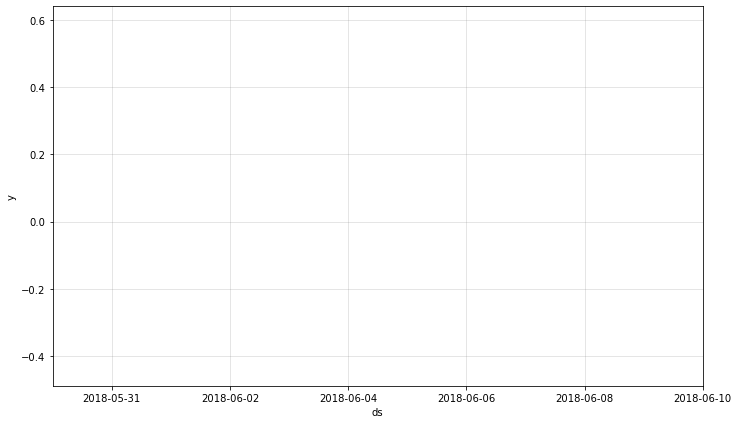

In [330]:
fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.xlim(pd.Timestamp('2018-05-30'), pd.Timestamp('2018-06-10'))

In [331]:
# # Cross validation
# cv = cross_validation(model, initial="365 days", period="30 days", horizon="10 days")
# perf = performance_metrics(cv)
# perf.index = pd.Index(perf.horizon.dt.days, name='days')
# perf

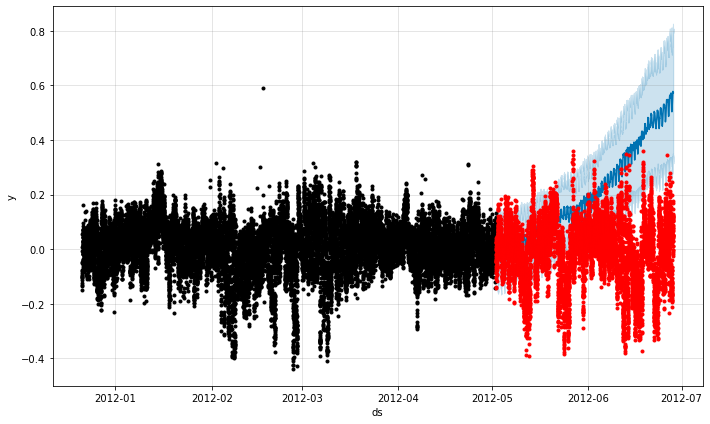

CPU times: user 1min 59s, sys: 4.63 s, total: 2min 4s
Wall time: 1min 23s


''

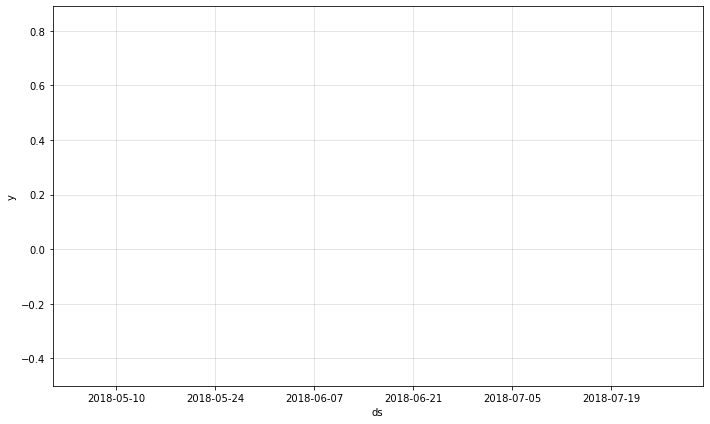

In [336]:
%%time
model = Prophet(
#     changepoint_range=0.8,
    yearly_seasonality=False,
    holidays=None,
    daily_seasonality=False,
    weekly_seasonality=False,
    holidays_prior_scale=0.001,
)
# add same periods as bcm see https://en.wikipedia.org/wiki/Theory_of_tides (additive)
model.add_seasonality(name='Moon2', period=12.4206012/24, fourier_order=4, prior_scale=40)
model.add_seasonality(name='Sun2', period=12/24, fourier_order=4, prior_scale=30)
model.add_seasonality(name='N2', period=12.65834751/24, fourier_order=1, prior_scale=10)

model.add_seasonality(name='K1', period=23.93447213/24, fourier_order=4, prior_scale=20)
model.add_seasonality(name='O1', period=25.81933871/24, fourier_order=1, prior_scale=10)

model.add_seasonality(name='Mm', period=27.554631896, fourier_order=4, prior_scale=4)
model.add_seasonality(name='Ssa', period=182.628180208, fourier_order=1, prior_scale=4)
model.add_seasonality(name='Sa', period=365.256360417, fourier_order=1, prior_scale=4)


model.add_seasonality(name='M4', period=6.210300601/24, fourier_order=1, prior_scale=2)
model.add_seasonality(name='M6', period=4.140200401/24, fourier_order=1, prior_scale=2)
model.add_seasonality(name='MK3', period=8.177140247/24, fourier_order=1, prior_scale=2)
model.fit(df_train)

forecast = model.predict(df_valid)
forecast.index = forecast.ds

fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.show()

fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.xlim(pd.Timestamp('2018-05'), pd.Timestamp('2018-08'))
''

(-0.1, 0.2)

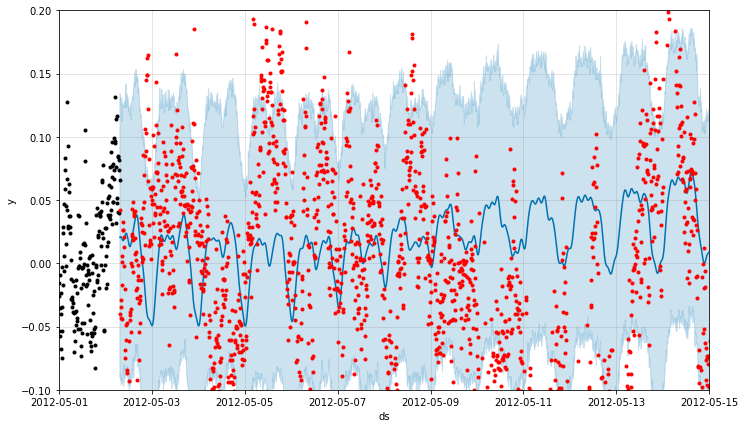

In [337]:
fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.xlim(pd.Timestamp('2012-05'), pd.Timestamp('2012-05-15'))
plt.ylim(-0.1, 0.2)

(-0.1, 0.2)

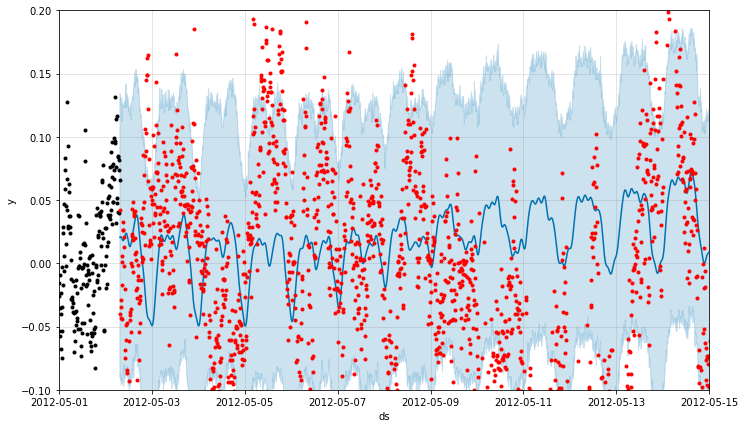

In [338]:
fig = model.plot(forecast)
fig.gca().plot(df_valid.index, df_valid['y'], 'k.', c='r', label='validation')
plt.xlim(pd.Timestamp('2012-05'), pd.Timestamp('2012-05-15'))
plt.ylim(-0.1, 0.2)

In [335]:
# # Cross validation
# cv = cross_validation(model, initial="365 days", period="30 days", horizon="10 days")
# perf = performance_metrics(cv)
# perf.index = pd.Index(perf.horizon.dt.days, name='days')
# perf